In [7]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from train_utils import update_dir_name, get_default_configs
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [10]:
training_config, model_config, cluster_config = get_default_configs(wandb_project="btbank_tests", random_string="X")

In [24]:
max_n_timebins = [12, 24, 48, 96]
sample_timebin_sizes = [0.25, 0.125, 0.0625, 0.03125]

random_strings = ["MTB1", "MTB2", "MTB3"]

# Initialize histories dict
histories = {sts: [] for sts in sample_timebin_sizes}

# Generate all run IDs and collect histories
for sts_idx, sts in enumerate(sample_timebin_sizes):
    for rs in random_strings:
        training_config['random_string'] = rs
        model_config['max_frequency_bin'] = None
        model_config['max_n_timebins'] = max_n_timebins[sts_idx]
        model_config['sample_timebin_size'] = sts   
        run_id = update_dir_name(model_config, training_config, cluster_config)
        
        runs = api.runs("andrii-mit/btbank_tests", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 100:  # Only include if trained for full 100 epochs
                histories[sts].append(history)

for sts in sample_timebin_sizes:
    print(f"sample timebin size {sts}: {len(histories[sts])} runs")

sample timebin size 0.25: 3 runs
sample timebin size 0.125: 2 runs
sample timebin size 0.0625: 3 runs
sample timebin size 0.03125: 3 runs


In [25]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3
measurement_at = 100//5

# Initialize results dictionary
results = {sts: {metric: [] for metric in metrics} 
          for sts in sample_timebin_sizes}

# Calculate means for each run
for sts in sample_timebin_sizes:
    for history in histories[sts]:
        for metric in metrics:
            h = np.array(list(history[metric].iloc))
            h = h[~np.isnan(h)]
            results[sts][metric].append(h[-n_last_measurements+measurement_at:measurement_at].mean())

# Print results
for sts in sample_timebin_sizes:
    print(f"\nmax frequency bin {sts}:")
    for metric in metrics:
        values = results[sts][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



max frequency bin 0.25:
train_loss: 0.5714 (across 3 runs)
test_loss: 0.7140 (across 3 runs)
eval_auroc/average_speech: 0.8093 (across 3 runs)
eval_auroc/average_volume: 0.6816 (across 3 runs)

max frequency bin 0.125:
train_loss: 0.5157 (across 2 runs)
test_loss: 0.5859 (across 2 runs)
eval_auroc/average_speech: 0.8360 (across 2 runs)
eval_auroc/average_volume: 0.7436 (across 2 runs)

max frequency bin 0.0625:
train_loss: 0.5849 (across 3 runs)
test_loss: 0.6102 (across 3 runs)
eval_auroc/average_speech: 0.8385 (across 3 runs)
eval_auroc/average_volume: 0.7293 (across 3 runs)

max frequency bin 0.03125:
train_loss: 0.4772 (across 3 runs)
test_loss: 0.4575 (across 3 runs)
eval_auroc/average_speech: 0.8069 (across 3 runs)
eval_auroc/average_volume: 0.7248 (across 3 runs)


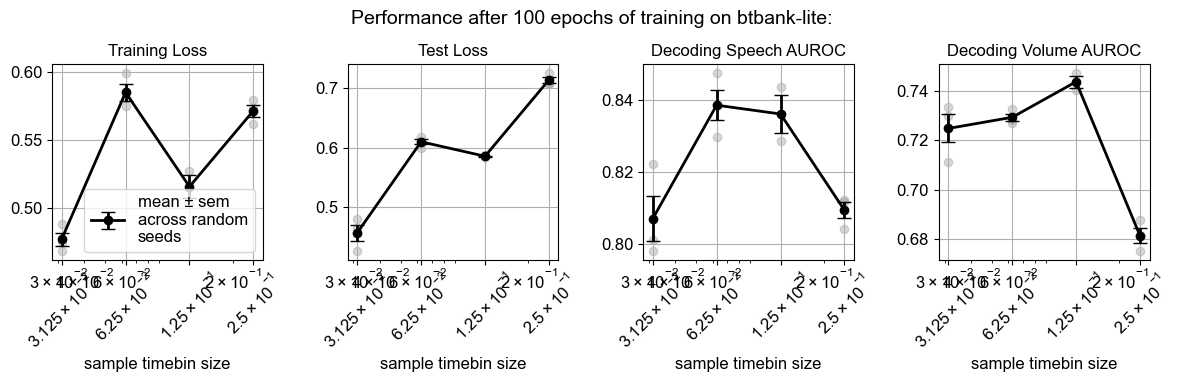

In [26]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3*len(metrics), 4))

for i, metric in enumerate(metrics):
    means = []
    errors = []
    ps = []
    all_values = []
    all_ps = []
    
    for sts in sample_timebin_sizes:
        values = results[sts][metric]
        if values:  # Only include if we have data
            means.append(np.mean(values))
            if error_type == 'std':
                errors.append(np.std(values))
            else:  # sem
                errors.append(np.std(values) / np.sqrt(len(values)))
            ps.append(sts)
            # Store individual points
            all_values.extend(values)
            all_ps.extend([sts] * len(values))
    
    # Plot individual points with some jitter and transparency
    jitter = 0.0
    axes[i].scatter(
        [p + np.random.uniform(-jitter, jitter) for p in all_ps],
        all_values,
        alpha=0.3,
        color='gray',
        zorder=1
    )
    
    # Plot mean and error bars on top
    error_label = 'mean ± std' if error_type == 'std' else 'mean ± sem'
    error_label += '\nacross random\nseeds'
    axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                    color='black', zorder=2, label=error_label,
                    linewidth=2)
    
    axes[i].set_xlabel('sample timebin size')
    #axes[i].set_ylabel('Value')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    axes[i].set_xscale('log')
    axes[i].set_xticks(sample_timebin_sizes)
    axes[i].tick_params(axis='x', rotation=45)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_mtb.pdf', bbox_inches='tight', dpi=300)
plt.show()
